In [1]:
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

random_state=42

<h2>Helper Functions</h2>

In [2]:
def display_dist(data):
    temp = data["sentiment"].value_counts()
    fig = px.bar(temp, x=temp.index, y=temp.values, color=temp.index.astype(str), width=600, height=300)
    fig.update_layout(
        title_text = "Data distribution for tweets sentiment",
        yaxis=dict(title="count"),
        xaxis=dict(title="label")
    )

    fig.update_xaxes(type="category", categoryorder="category ascending")

    fig.show()

In [3]:
# Tweets preprocessing.

stopw = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):

    tweet = tweet.lower()

    # Remove twitter handels (@user)
    tweet = re.sub("@[a-z0-9:]+", "", tweet)

    # Remove RT
    tweet = re.sub("rt ", "", tweet)

    # Remove http links
    tweet = re.sub(r"http\S+", "", tweet) 
    

    # Remove hashtag sign but keep the text
    tweet = tweet.replace("#", "").replace("_", " ") 

    # Remove punctuations
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)

    # Remove all non-alphanumeric character
    tweet = re.sub("[^a-z0-9]"," ", tweet)

    # Stop word removal and lemmatization
    tweet = tweet.split()
    tweet = [w for w in tweet if not w in stopw]
    tweet = [lemmatizer.lemmatize(w) for w in tweet ]
    tweet = " ".join(word for word in tweet)

    return tweet
    
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

In [4]:
def wrapper(train, test):
    # Apply tweets preprocessing.
    train["message_clean"] = train["message"].apply(lambda x: clean_tweet(x))
    test["message_clean"] = test["message"].apply(lambda x: clean_tweet(x))

    # Prepare datasets for ML model.
    X_train = train["message_clean"].values.reshape(-1, 1)
    y_train = train["sentiment"]

    X_test = test["message_clean"].values.reshape(-1, 1)
    y_test = test["sentiment"]

    # Balancing.
    sampler = RandomOverSampler(random_state=random_state)
    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

    # Create the random forest model.
    rf = RandomForestClassifier(random_state=random_state)

    # Create TF-IDF Vectorizer.
    tfidf_converter = TfidfVectorizer()

    # Create the pipeline.
    pipeline = Pipeline(steps=[ ("tf_idf", tfidf_converter), ("classification", rf) ])

    # Search parameters for bayesian optimization.
    param_grid = {
        "tf_idf__max_df": (0.7, 1.0),
        "tf_idf__min_df": (0.0, 0.3),
        "classification__n_estimators": (100, 1000),
        "classification__max_depth": (10, 1500),
        "classification__min_samples_split": (2, 10),
        "classification__min_samples_leaf": (1, 10)
    }

    # n_iter, cv and n_jobs can be adjusted to differentiate between accuracy and speed.
    bayes_search_estimator = BayesSearchCV(estimator=pipeline, search_spaces=param_grid, n_iter=20, cv=3, n_jobs=-2, random_state=random_state)

    # Fit the model.
    bayes_search_estimator.fit(X_train_sampled.ravel(), y_train_sampled)

    # Print best accuracy and hyperparameters.
    print(f"Best accuracy: {bayes_search_estimator.best_score_*100:.2f}%")
    print(f"Best hyperparameters: {bayes_search_estimator.best_params_}")

    # Get best estimator from bayes search.
    estimator = bayes_search_estimator.best_estimator_

    # Predict class labels.
    y_pred = estimator.predict(X_test.ravel())

    # Display classification report and confusion matrix.
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.show()

    # Return best TF-IDF and ML model.
    return estimator["tf_idf"], estimator["classification"]

<h3>Machine Learning</h3>
Our sentiment analysis task is to predict whether a climate change related tweet and the beliefs it reflects falls into one of four categories:

- Anti (Climate change denier)
- Neutral (Neutral towards the topic)
- Pro (Climate change believer)
- Factual News (Factual news attached that cites a credible source towards the existence of climate change)

The first three categories are typical in the context of sentiment analysis, while the fourth category may be kind of out of place. Thus, we decided, in consultation with our tutor, that we test three approaches in handling this category:

Leave it as it is (Normal approach)
Drop all rows labelled as this class (Dropping approach)
Replacing it with the "Pro" label, as it could be interpreted that way (Replacing approach)
In the following, we will compare the results of all three approaches.

<h3>Normal approach</h3>

In [5]:
train = pd.read_csv("./data/trainset.csv")
test = pd.read_csv("./data/testset.csv")

In [6]:
display_dist(train)

In [18]:
tf_idf_normal, rf_normal = wrapper(train, test)

<h3>Dropping approach</h3>

In [8]:
train_drop = train[train["sentiment"] != 2].copy(deep=True)
test_drop = test[test["sentiment"] != 2].copy(deep=True)

In [9]:
display_dist(train_drop)

Best accuracy: 92.24%
Best hyperparameters: OrderedDict([('classification__max_depth', 1500), ('classification__min_samples_leaf', 1), ('classification__min_samples_split', 2), ('classification__n_estimators', 1000), ('tf_idf__max_df', 0.7), ('tf_idf__min_df', 0.0)])
              precision    recall  f1-score   support

          -1       0.66      0.45      0.53       771
           0       0.55      0.50      0.53      1501
           1       0.80      0.87      0.83      4120

    accuracy                           0.73      6392
   macro avg       0.67      0.61      0.63      6392
weighted avg       0.72      0.73      0.73      6392



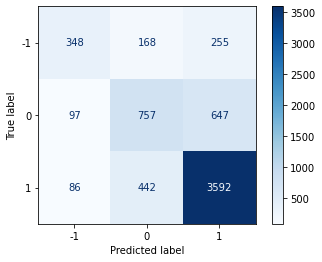

In [10]:
tf_idf_drop, rf_drop = wrapper(train_drop, test_drop)

<h3>Replacing approach</h3>

In [11]:
train_replace = train.copy(deep=True)
train_replace["sentiment"] = train_replace["sentiment"].replace(2, 1)

test_replace = test.copy(deep=True)
test_replace["sentiment"] = test_replace["sentiment"].replace(2, 1)

In [12]:
display_dist(train_replace)

In [17]:
tf_idf_replace, rf_replace = wrapper(train_replace, test_replace)

KeyboardInterrupt: 

<h4>The accuracy results speak for themselves:</h4>

- Normal approach: Train: 0.90, Test: 0.66
- Dropping approach: Train: 0.92, Test: 0.73
- Replacing approach: Train: 0.95, Test: 0.78


<h3>Feature importance</h3>

As the replacing approach seemed to perform best, we will take a look at the feature importance of the logistic regression model.

In [ ]:
# Get feature names from tf-idf.
feature_names = tf_idf_replace.get_feature_names_out()

# Get feature importances from random forest model.
importances = rf_replace.feature_importances_

# Create dataframe.
feature_importance = pd.DataFrame(feature_names, columns=["feature"])
feature_importance["importance"] = importances
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False).head(20)

# Visualize feature importance.
fig = px.bar(feature_importance, y="feature", x="importance", orientation="h",  title ="Feature Importance in Random Forest model", width=800, height=500, labels={"feature": "Feature Name", "importance": "Mean decrease in impurity"}, color="feature")
fig.update_layout(yaxis={"categoryorder":"total ascending"})
fig.show()

NameError: name 'rf_replace' is not defined

You can see that the ML model is able to differentiate based on terms like "alarmist" / "alarmism", "histeria", "fakenews", "spicier", "globalist", "faked", etc.. By taking a calculated guess, you could probably attribute all these terms to the anti climate change sentiment. Taking the results of the confusion matrix into account, one can see that the ML model has more trouble to differentiate between neutral and pro sentiment compared to the anti sentiment. This matches the findings of feature importances in where most terms could be attributed to an anti climate change sentiment. Therefore, the ML model assigns the highest feature importance to these terms and thus can more easily distinguish between an anti sentiment to neutral / pro sentiment than between the later two sentiments themselves.